https://github.com/udacity/CarND-Behavioral-Cloning-P3

### train the steering with input is center image

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the data
!unzip /content/drive/MyDrive/train_data.zip -d /content/drive/MyDrive/train_data

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/train_data/IMG/left_2022_03_06_17_14_43_186.jpg  
  inflating: /content/drive/MyDrive/train_data/IMG/left_2022_03_06_17_14_43_344.jpg  
  inflating: /content/drive/MyDrive/train_data/IMG/left_2022_03_06_17_14_43_415.jpg  
  inflating: /content/drive/MyDrive/train_data/IMG/left_2022_03_06_17_14_43_461.jpg  
  inflating: /content/drive/MyDrive/train_data/IMG/left_2022_03_06_17_14_43_560.jpg  
  inflating: /content/drive/MyDrive/train_data/IMG/left_2022_03_06_17_14_43_666.jpg  
  inflating: /content/drive/MyDrive/train_data/IMG/left_2022_03_06_17_14_43_783.jpg  
  inflating: /content/drive/MyDrive/train_data/IMG/left_2022_03_06_17_14_43_898.jpg  
  inflating: /content/drive/MyDrive/train_data/IMG/left_2022_03_06_17_14_43_965.jpg  
  inflating: /content/drive/MyDrive/train_data/IMG/left_2022_03_06_17_14_44_100.jpg  
  inflating: /content/drive/MyDrive/train_data/IMG/left_2022_03_06_17_14_44_175.jpg  
  i

In [2]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

In [4]:
# Get the dataframe
df = pd.read_csv('/content/drive/MyDrive/train_data/driving_log.csv',names = ['center','left','right','steering','throttle','reverse','speed'])
df.head()

,center,left,right,steering,throttle,reverse,speed
0,D:\ML\beta_simulator_windows\train_data\IMG\ce...,D:\ML\beta_simulator_windows\train_data\IMG\le...,D:\ML\beta_simulator_windows\train_data\IMG\ri...,0.0,0.0,0,0.000008
1,D:\ML\beta_simulator_windows\train_data\IMG\ce...,D:\ML\beta_simulator_windows\train_data\IMG\le...,D:\ML\beta_simulator_windows\train_data\IMG\ri...,0.0,0.0,0,0.000009
2,D:\ML\beta_simulator_windows\train_data\IMG\ce...,D:\ML\beta_simulator_windows\train_data\IMG\le...,D:\ML\beta_simulator_windows\train_data\IMG\ri...,0.0,0.0,0,0.000010
3,D:\ML\beta_simulator_windows\train_data\IMG\ce...,D:\ML\beta_simulator_windows\train_data\IMG\le...,D:\ML\beta_simulator_windows\train_data\IMG\ri...,0.0,0.0,0,0.000012
4,D:\ML\beta_simulator_windows\train_data\IMG\ce...,D:\ML\beta_simulator_windows\train_data\IMG\le...,D:\ML\beta_simulator_windows\train_data\IMG\ri...,0.0,0.0,0,0.000013


In [5]:
# Get the directories of image 
X_dir = df['center'].values
X_dir = list(X_dir)
print(f'We have {len(X_dir)} center images')

We have 3298 center images


In [6]:
path = '/content/drive/MyDrive/train_data/IMG/' + X_dir[0].split('\\')[-1]
path

'/content/drive/MyDrive/train_data/IMG/center_2022_03_06_17_12_32_776.jpg'

In [7]:
paths = [ '/content/drive/MyDrive/train_data/IMG/' + x.split('\\')[-1] for x in X_dir]
paths

['/content/drive/MyDrive/train_data/IMG/center_2022_03_06_17_12_32_776.jpg',
 '/content/drive/MyDrive/train_data/IMG/center_2022_03_06_17_12_32_855.jpg',
 '/content/drive/MyDrive/train_data/IMG/center_2022_03_06_17_12_32_945.jpg',
 '/content/drive/MyDrive/train_data/IMG/center_2022_03_06_17_12_33_019.jpg',
 '/content/drive/MyDrive/train_data/IMG/center_2022_03_06_17_12_33_096.jpg',
 '/content/drive/MyDrive/train_data/IMG/center_2022_03_06_17_12_33_211.jpg',
 '/content/drive/MyDrive/train_data/IMG/center_2022_03_06_17_12_33_318.jpg',
 '/content/drive/MyDrive/train_data/IMG/center_2022_03_06_17_12_33_429.jpg',
 '/content/drive/MyDrive/train_data/IMG/center_2022_03_06_17_12_33_516.jpg',
 '/content/drive/MyDrive/train_data/IMG/center_2022_03_06_17_12_33_588.jpg',
 '/content/drive/MyDrive/train_data/IMG/center_2022_03_06_17_12_33_679.jpg',
 '/content/drive/MyDrive/train_data/IMG/center_2022_03_06_17_12_33_771.jpg',
 '/content/drive/MyDrive/train_data/IMG/center_2022_03_06_17_12_33_867.jpg',

In [8]:
# Load and display the image
def load_and_prep_image(filename,image_shape = 224):
  '''
  load image from the path , turn it into tensor and display it
  Arguments:
  filename --- the file's path
  image_shape --- the shape of image
  Return:
  img --- image tensor
  '''
  # Read image from path
  img = tf.io.read_file(filename)
  # Decode it into tensor
  img = tf.image.decode_image(img,channels = 3)
  # Resize the image to the same size we train
  img = tf.image.resize(img,size = [image_shape,image_shape])
  # Normalization the img
  img = img *1./255
  return img

Text(0.5, 1.0, 'center_2022_03_06_17_12_32_776.jpg')

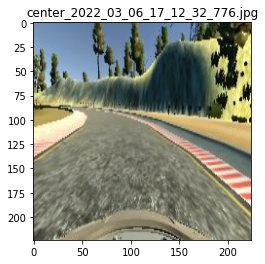

In [11]:
img = load_and_prep_image(paths[0],image_shape = 224)
plt.imshow(img)
plt.title(paths[0].split('/')[-1])

In [12]:
img = tf.expand_dims(img,axis = 0)
img.shape

TensorShape([1, 224, 224, 3])

In [13]:
img = tf.concat([img,
                 tf.expand_dims(load_and_prep_image(paths[1],image_shape = 224),axis = 0)],
                axis =0)
img.shape

TensorShape([2, 224, 224, 3])

In [14]:
# Create the first img in dataset
X = tf.expand_dims(load_and_prep_image(paths[0],image_shape = 224),axis = 0)
print(X.shape)

(1, 224, 224, 3)


In [15]:
from tqdm import tqdm, trange

for i in tqdm(range(1,len(paths))):
  X = tf.concat([X,tf.expand_dims(load_and_prep_image(paths[i],image_shape = 224),axis = 0)],axis =0)
  
print(f'number of image: {len(paths)}')
print(f'X.shape: {X.shape}')

100%|██████████| 3297/3297 [22:56<00:00,  2.40it/s]

number of image: 3298
X.shape: (3298, 224, 224, 3)


In [ ]:
import sys
from time import sleep
for i in range(21):
  sys.stdout.write('\r')
  # the exact ouput you are looking for:
  sys.stdout.write('[%-20s] %d%%' % ('='*i,5*i))
  sys.stdout.flush()
  sleep(0.25)

[====================] 100%

In [ ]:
from tqdm import tqdm, trange
import time
for i in tqdm(range(1,len(paths))):
  #print(i)
  sleep(0.01)

100%|██████████| 3297/3297 [00:34<00:00, 95.66it/s]


In [16]:
y = df['steering'].values
#y = tf.constant(y,dtype = tf.float32)
# y = y.reshape(-1,1)
y.shape
# y = tf.constant(y)
# y.shape

(3298,)

Text(0.5, 1.0, 'hist-steering')

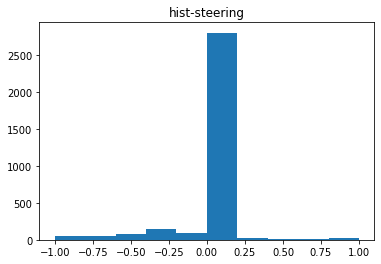

In [17]:
plt.hist(y)
plt.title('hist-steering')

Text(0.5, 1.0, 'plot-steering')

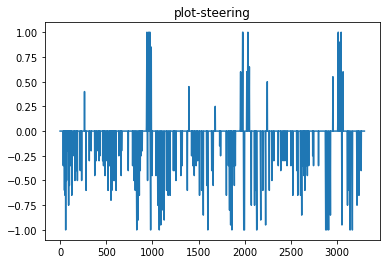

In [18]:
plt.plot(y)
plt.title('plot-steering')

In [19]:
X_32 = tf.cast(X,tf.float32)

In [20]:
sl = round(0.6 * len(paths))
print(f"split at value {sl}")
X_train = X[:sl]
X_test = X[sl:]
y_train = y[:sl]
y_test = y[sl:]

split at value 1979


In [37]:
print(f'X_train.shape {X_train.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (1979, 224, 224, 3)
y_train.shape (1979,)
X_test.shape (1319, 224, 224, 3)
y_test.shape (1319,)


In [22]:
X[0].dtype

tf.float32

In [59]:
model  = tf.keras.Sequential([
                              tf.keras.layers.Conv2D(filters = 10,
                                                     kernel_size = (3,3),
                                                     activation = 'elu',
                                                     input_shape = (224,224,3)
                                                      ),
                              tf.keras.layers.Conv2D(filters = 10,
                                                     kernel_size = (3,3),
                                                     activation = 'elu'
                                                      ),
                              tf.keras.layers.MaxPool2D(pool_size = (2,2)),
                              tf.keras.layers.Conv2D(filters = 10,
                                                     kernel_size = (3,3),
                                                     activation = 'elu'
                                                      ),
                              tf.keras.layers.Conv2D(filters = 10,
                                                     kernel_size = (3,3),
                                                     activation = 'elu'
                                                      ),
                              tf.keras.layers.MaxPool2D(pool_size = (2,2)),
                              tf.keras.layers.Conv2D(filters = 10,
                                                     kernel_size = (3,3),
                                                     activation = 'elu'
                                                      ),
                              tf.keras.layers.Conv2D(filters = 10,
                                                     kernel_size = (3,3),
                                                     activation = 'elu'
                                                      ),
                              tf.keras.layers.MaxPool2D(pool_size = (2,2)),
                              tf.keras.layers.Conv2D(filters = 10,
                                                     kernel_size = (3,3),
                                                     activation = 'elu'
                                                      ),
                              tf.keras.layers.Conv2D(filters = 10,
                                                     kernel_size = (3,3),
                                                     activation = 'elu'
                                                      ),
                              tf.keras.layers.MaxPool2D(pool_size = (2,2)),
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(128,activation = 'elu'),
                              tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_41 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_43 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                 

In [60]:
model.compile(loss = tf.keras.losses.mean_squared_error,
              optimizer = tf.keras.optimizers.Adam(),
              metrics  =['accuracy']
              )

In [63]:
# Early stopping
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/model-{epoch:03d}.h5',
                                               monitor = 'val_loss',
                                               verbose = 0,
                                               save_best_only = True,
                                               mode = 'auto')

In [1]:
history = model.fit(X_train,y_train,
                    epochs = 1,
                    validation_data = (X_test,y_test),
                    validation_steps = len(y_test),
                    callbacks = [checkpoint],
                    verbose = 1
                    )

NameError: ignored

In [53]:
# Evaluate model
model.evaluate(X_test,y_test,verbose = 1)

42/42 [==============================] - 24s 570ms/step - loss: 0.0478 - accuracy: 0.8431


[0.04783151298761368, 0.8430629372596741]

In [56]:
def plot_loss_curves(history):
  '''
  Plot seperatly the loss and the accuracy
  '''
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(loss))
  # Plot loss curve
  plt.plot(epochs,loss,label = 'loss')
  plt.plot(epochs,val_loss,label = 'val_loss')
  plt.title('Loss')
  plt.legend()
  # Plot accuracy curve
  plt.figure()
  plt.plot(epochs,accuracy,label = 'accuracy')
  plt.plot(epochs,val_accuracy,label = 'val_accuracy')
  plt.legend()
  plt.title('val_accuracy')


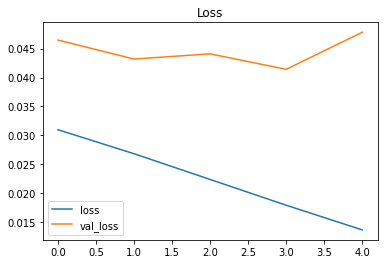

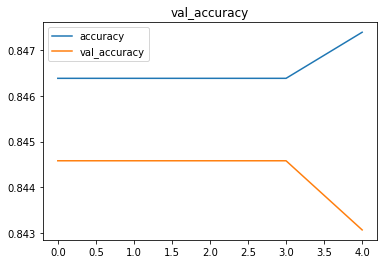

In [57]:
plot_loss_curves(history)

In [58]:
# Save your model
model.save('model5.h5')